In [1]:
#Imports
import time                     #For progress indicator
import sys
import numpy as np              #Will be used for binning
import pandas as pd             #Will be used for data structuring
import lmfit as lf              #Fitting
import matplotlib.pyplot as plt #Basic plotting library
sys.path.append('./')
from R76Tools import *          #Tools written by me for, e.x., importing our files

#Constants
frittspath = "/data/chocula/fritts/data/k100proc/midasrq/byseries/"
neogpath = "/data/chocula/neog/rq/"
baselinecorrections = pd.read_csv("./baselinecorrectionvalues.csv")
gaus_mod = lf.Model(gaus)
gaus_params = gaus_mod.make_params()
gaus_params.add('A',min=0,value=300)
gaus_params.add('sigma',min=0,value=3,max=200)
gaus_params.add('mu',min=100,max=300,value=150)
cal_mod = lf.Model(E_cal)
cal_params = cal_mod.make_params(a=300,c=13)

In [15]:
#User-set Variables
ser = ["07221119_1016","07221124_1408","07221124_1603","07221124_1748","07221124_2022"\
      ,"07221124_2331"]
paths=[frittspath,frittspath,frittspath,frittspath,frittspath,frittspath]
lab = [-81.5,-8.3,-16.3,-24,-34,-34] # Actually relevant here
for i in range(len(ser)):
    m,b=0,0
    for j in range(len(baselinecorrections)): # Pull m and b values from the csv
        if baselinecorrections.series[j]==ser[i]:
            m,b=1,1
    if ((m==0) or (b==0)):
        print("Oops! Series",ser[i],"doesn't have its correction values in the proper csv.")
print((len(ser)==len(paths))and(len(paths)==len(lab)))
z=[]
t=int(time.time())
print(t)
#Derived variables
for i,s in enumerate(ser):
    print("Progress: "+str(i)+"/"+str(len(ser))+". This action took "+str(round((time.time()-t)/60,1))+" minutes.")
    t=int(time.time())
    _,z_chain = makechain(paths[i]+s+"/umn_*.root",filters=[fittingfilters,"PTOFamps0"],aliases=calibrationaliases)
    z.append(z_chain) # Do it this roundabout way to accommodate having Matt's and Himangshu's data in ser
print("Progress: "+str(i+1)+"/"+str(len(ser))+". This action took "+str(round((time.time()-t)/60,1))+" minutes.")

True
1691522854
Progress: 0/6. This action took 0.0 minutes.
Progress: 1/6. This action took 6.8 minutes.
Progress: 2/6. This action took 1.7 minutes.
Progress: 3/6. This action took 2.1 minutes.
Progress: 4/6. This action took 3.1 minutes.
Progress: 5/6. This action took 2.5 minutes.


KeyboardInterrupt: 

In [12]:
# Fix up the names
cam=[]
for i,x in enumerate(z):
    cam.append((x['phidel']>-70)&(x['phidel']<50))
    m,b=0,0
    for j in range(len(baselinecorrections)): # Pull m and b values from the csv
        if baselinecorrections.series[j]==ser[i]:
            m=baselinecorrections.m[j]
            b=baselinecorrections.b[j]
    if ((m==0) or (b==0)):
        print("Oops! Series",ser[i],"doesn't have its correction values in the proper csv.")
    x["pt_keV_bscorr"] = x["pt_keV"]/(1+m*x["BSel"]/b)
    x["pt0_keV_bscorr"] = x["pt0_keV"]/(1+m*x["BSel"]/b)

# Finding sigma_0:

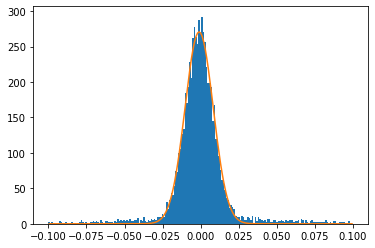

[0.00925046108382066]

In [13]:
hn=[]; sigma0_values=[]
for i,x in enumerate(z):
    x["pt_keVee_root"] = 13.1849*x["pt_keV_bscorr"]/(297.667-x["pt_keV_bscorr"])
    x["pt0_keVee_root"] = 13.1849*x["pt0_keV_bscorr"]/(297.667-x["pt0_keV_bscorr"])
    hn.append(plt.hist(x["pt0_keVee_root"][x["crand"] & x["cbs"]],bins=np.linspace(-0.1,0.1,200)))
    gaus_params.add('mu',value=0,min=-0.1,max=0.1)
    bins = (hn[i][1][:-1]+hn[i][1][1:])/2
    fit_NTL = gaus_mod.fit(hn[i][0],gaus_params,x=bins)#,weights=1/np.sqrt(h4n[0]))
    sigma0_values.append(fit_NTL.params['sigma'].value)
    plt.plot(bins,fit_NTL.best_fit)
plt.show() # Ignore this plot
sigma0_values

In [14]:
for i in range(len(ser)):
    print(ser[i]+","+str(round(sigma0_values[i],4))+","+str(lab[i]))

07221118_1404,0.0093,-81.6


IndexError: list index out of range

# Is there a correlation between lab voltage and sigma values?

In [16]:
widthvalues = pd.read_csv("./widthstudyvalues.csv")
voltagevalues, sigma0values, sigma80, sigma200=[],[],[],[]
for i in range(len(widthvalues.series)):
    voltagevalues.append(widthvalues.lab[i])
    sigma0values.append(widthvalues.sigma0[i])
    if ((voltagevalues[i]<-75)and(voltagevalues[i]>-85)):
        sigma80.append(widthvalues.sigma0[i])
    if ((voltagevalues[i]<-195)and(voltagevalues[i]>-205)):
        sigma200.append(widthvalues.sigma0[i])
voltagevalues=np.asarray(voltagevalues)
sigma0values=np.asarray(sigma0values)
sigma200=np.asarray(sigma200)
sigma80=np.asarray(sigma80)

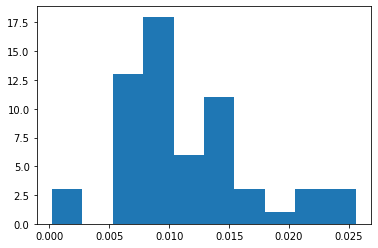

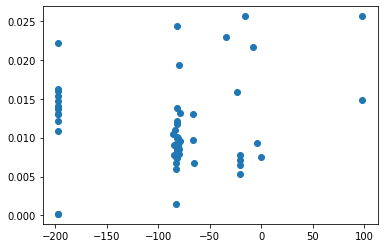

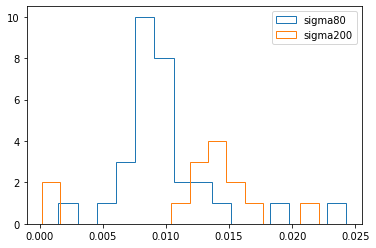

sigma80 average: 9.776666666666664 eVee. sigma80 std. deviation: 3.9618752574450844 eVee
sigma200 average: 12.542857142857144 eVee. sigma200 std. deviation: 5.631127048534307 eVee


In [22]:
plt.hist(sigma0values)
plt.show()
plt.scatter(voltagevalues,sigma0values)
plt.show()
plt.hist(sigma80,histtype="step",bins=15)
plt.hist(sigma200,histtype="step",bins=15)
plt.legend(["sigma80","sigma200"])
plt.show()
print("sigma80 average:",np.mean(sigma80)*1000,"eVee.","sigma80 std. deviation:",np.std(sigma80)*1000,"eVee")
print("sigma200 average:",np.mean(sigma200)*1000,"eVee.","sigma200 std. deviation:",np.std(sigma200)*1000,"eVee")